# DSCI 563: Unsupervised Learning 

## Lecture 2: DBSCAN and Hierarchical Clustering

UBC Master of Data Science program, 2020-21

Instructor: Varada Kolhatkar

<br><br>

### Imports 

In [1]:
import os
import random
import sys

import numpy as np
import pandas as pd

sys.path.append("code/.")
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
from ipywidgets import interactive
from plotting_functions import *
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn import cluster, datasets, metrics
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from support_functions import *
from yellowbrick.cluster import SilhouetteVisualizer

plt.rcParams["font.size"] = 16
# plt.style.use("seaborn")
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

ModuleNotFoundError: No module named 'support_functions'

<br><br>

## Table of contents

- [Learning outcomes](#lo)
- [Video 1: Recap and motivation](#1)
- [Video 2: DBSCAN](#2)
- [Video 3: Hierarchical clustering](#3)
- [Video 4: Clustering on Faces in the Wild (LFW) people dataset](#4)
- [Video 5: Final comments and summary](#5)
- [Questions for class discussion](#questions)

<br><br>

## Learning outcomes <a name="lo"></a>

From this lecture, students are expected to be able to:

- Identify limitations of K-Means.
- Explain how DBSCAN works at a high level.
- Use `sklearn` to apply DBSCAN. 
- Explain the effect of epsilon and minimum samples hyperparameters in DBSCAN.  
- Identify DBSCAN limitations.
- Explain the idea of hierarchical clustering.
- Visualize dendrograms using `scipy.cluster.hierarchy.dendrogram`.    
- Explain the advantages and disadvantages of different clustering methods. 
- Apply clustering algorithms on image datasets and interpret clusters. 
- Recognize the impact of distance measure and representation in clustering methods. 

<br><br><br><br>

## Video 1: Recap and motivation <a name="1"></a>

### K-Means recap 
- We discussed K-Means clustering in the previous lecture. 
- Each cluster is represented by a center. 
- Given a new point, you can assign it to a cluster by computing the distances to all cluster centers and picking the cluster with the smallest distance. 
- It's a popular algorithm because 
    - It's easy to understand and implement.
    - Runs relatively quickly and scales well to large datasets. 
    - `sklearn` has a more scalable variant called [`MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) which can handle very large datasets. 

### K-Means limitations

- Relies on random initialization and so the outcome may change depending upon this initialization. 
- K-Means clustering requires to specify the number of clusters in advance.
- Very often you do not know the centers in advance. The elbow method or the silhouette method to find the optimal number of clusters are not always easy to interpret. 
- Each point has to have a cluster assignment. 

### K-Means limitations: Shape of K-Means clusters

- K-Means partitions the space based on the closest mean. 
- Each cluster is defined solely by its center and so it can only capture relatively simple shapes. 
- So the boundaries between clusters are linear; It fails to identify clusters with complex shapes. 

<center>
<img src="img/kmeans_boundaries.png" alt="" height="500" width="500"> 
</center>    

[Source](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)

### K-Means: failure case 1

- K-Means performs poorly if the clusters have more complex shapes (e.g., two moons data below). 

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=42)
plot_X_k_means(X, k=2)

### K-Means: failure case 2

- It assumes that all directions are equally important for each cluster and fails to identify non-spherical clusters. 

In [ ]:
# generate some random cluster data
X, y = make_blobs(random_state=170, n_samples=200)
rng = np.random.RandomState(74)
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)
plot_X_k_means(X, 3)

### K-Means: failure case 3 

- Again, K-Means is unable to capture complex cluster shapes. 

In [ ]:
X = datasets.make_circles(n_samples=200, noise=0.06, factor=0.4)[0]
plot_X_k_means(X, 2)

- Can we do better than this? 
- Another clustering algorithm called DBSCAN is able to tackle some of these cases. 

<br><br><br><br><br><br>

## Video 2: DBSCAN <a name="2"></a> 

- **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise

### DBSCAN introduction

- DBSCAN is a density-based clustering algorithm. 
- Intuitively, it's based on the idea that clusters form dense regions in the data and so it works by identifying "crowded" regions in the feature space. 
- It can address some of the limitations of K-Means we saw above. 
    - It does not require the user to specify the number of clusters in advance. 
    - It can identify points that are not part of any clusters. 
    - It can capture clusters of complex shapes. 

Let's try `sklearn`'s DBSCAN.   

In [ ]:
X, y = make_moons(n_samples=200, noise=0.08, random_state=42)
dbscan = DBSCAN(eps=0.2)
dbscan.fit(X)
plot_X_dbscan(X, dbscan)

In [ ]:
dbscan.labels_

- DBSCAN is able to capture half moons shape
- We don't not have to specify the number of clusters. 
    - That said, it has two other non-trivial hyperparameters to tune. 
- There are two examples which have not been assigned any label (noise examples). 

One more example of DBSCAN clusters capturing complex cluster shapes. 

In [ ]:
X = datasets.make_circles(n_samples=200, noise=0.06, factor=0.4)[0]
dbscan = DBSCAN(eps=0.3, min_samples=3)
dbscan.fit(X)
plot_X_dbscan(X, dbscan)

### How does it work?

- Iterative algorithm.  
- Based on the idea that clusters form dense regions in the data. 

<center>
<img src="img/DBSCAN_search.gif" alt="" height="900" width="900"> 
</center>

[Source](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)

### Two main hyperparameters
- `eps`: determines what it means for points to be "close"
- `min_samples`: determines the number of **neighboring points** we require to consider in order for a point to be part of a cluster

### Effect of `eps` hyperparameter

In [ ]:
interactive(lambda eps=1: print(eps), eps=(1, 12, 1))

In [ ]:
X, y = make_blobs(random_state=40, centers=2, n_samples=6)
interactive(lambda eps=1: plot_dbscan_with_labels(X, eps), eps=(1, 12, 1))

In [ ]:
pd.DataFrame(euclidean_distances(X, X)).round()

### Effect of `min_samples` hyperparameter

In [ ]:
interactive(
    lambda min_samples=1: plot_dbscan_with_labels(X, eps=2.0, min_samples=min_samples),
    min_samples=(1, 5, 1),
)

### More details on DBSCAN

There are three kinds of points.

- **Core points** are the points that have at least `min_samples` points in the neighborhood.

- **Border points** are the points with fewer than `min_samples` points in the neighborhood, but are connected to a core point. 

- **Noise points** are the points which do not belong to any cluster. In other words, the points which have less that `min_samples` point within distance `eps` of the starting point are noise points. 


### DBSCAN algorithm 

- Pick a point $p$ at random.
- Check whether $p$ is a "core" point or not. You can check this by looking at the number of neighbours within epsilon distance if they have at least `min_samples` points in the neighbourhood
- If $p$ is a core point, give it a colour (label). 
- Spread the colour of $p$ to all of its neighbours.
- Check if any of the neighbours that received the colour is a core point, if yes, spread the colour to its neighbors as well.
- Once there are no more core points left to spread the colour, pick a new unlabeled point $p$ and repeat the process.

### K-Means vs. DBSCAN

- In DBSCAN, you do not have to specify the number of clusters! 
    - Instead, you have to tune `eps` and `min_samples`. 
- Unlike K-Means, DBSCAN doesn't have to assign all points to clusters. 
    - The label is -1 if a point is unassigned.
- Unlike K-Means, there is no `predict` method. 
    - DBSCAN only really clusters the points you have, not "new" or "test" points.

### Illustration of hyperparameters `eps` and `min_samples`

In [ ]:
X, y = make_blobs(random_state=0, n_samples=12)
mglearn.discrete_scatter(X[:, 0], X[:, 1]);

In [ ]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)
print("Cluster memberships:{}".format(clusters))

- Default values for hyperparameters don't work well on toy datasets. 
- All points have been marked as noise with the default values for `eps` and `min_samples`
- Let's examine the effect of changing these hyperparameters. 
    - noise points: shown in white
    - core points: bigger
    - border points: smaller

In [ ]:
mglearn.plots.plot_dbscan()

### Observations

- Increasing `eps` ($\uparrow$) (left to right in the plot above) means more points will be included in a cluster. 
    - `eps` = 1.0 either creates more clusters or more noise points, whereas eps=3.0 puts all points in one cluster with no noise points.  
- Increasing `min_samples` ($\uparrow$) (top to bottom in the plot above) means points in less dense regions will either be labeled as their own cluster or noise. 
    - `min_samples=2`, for instance, has none or only a fewer noise points whereas `min_samples=5` has several noise points. 
- Here `min_samples` = 2.0 or 3.0 and `eps` = 1.5 is giving us the best results. 
- In general, it's not trivial to tune these hyperparameters. 


### Question for you

- Does the order that you pick the points matter in DBSCAN?
<br><br><br><br>

> No. Any of the cluster's core points is able to fully identify the cluster, with no randomness involved. The only possible conflict you might get is that if two clusters have the same border point. In this case the assignment will be implementation dependent, but usually the border point will be assigned to the first cluster that "finds" it. 

### Evaluating DBSCAN clusters 
- We cannot use the elbow method to examine the goodness of clusters created with DBSCAN. 
- But we can use the silhouette method because it's not dependent on the idea of cluster centers. 

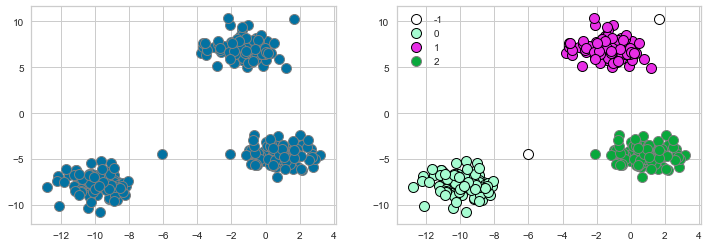

In [14]:
X, y = make_blobs(random_state=100, centers=3, n_samples=300)
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan.fit(X)
plot_X_dbscan(X, dbscan)

In [15]:
# Yellowbrick is designed to work with K-Means and not with DBSCAN.
# So it needs the number of clusters stored in n_clusters
# It also needs `predict` method to be implemented.
# So I'm implementing it here so that we can use Yellowbrick to show Silhouette plots.
n_clusters = len(set(dbscan.labels_))
dbscan.n_clusters = n_clusters
dbscan.predict = lambda x: dbscan.labels_

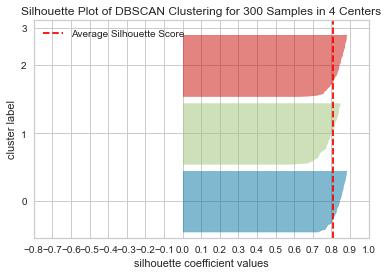

In [16]:
visualizer = SilhouetteVisualizer(dbscan, colors="yellowbrick")
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show();

### Summary: Pros and cons

- Pros
    - Can learn arbitrary cluster shapes
    - Can detect outliers 
- Cons
    - Cannot `predict` on new examples.  
    - Needs tuning of two non-obvious hyperparameters 

There is an improved version of DBSCAN called [`HDBSCAN` (hierarchical DBSCAN)](https://github.com/scikit-learn-contrib/hdbscan). 

### DBSCAN: failure cases

- DBSCAN is able to capture complex clusters. But this doesn't mean that `DBSCAN` always works better. It has its own problems! 
- DBSCAN doesn't do well when we have clusters with different densities. 
    - You can play with the hyperparameters but it's not likely to help much.

### DBSCAN: failure cases

- Let's consider this dataset with three clusters of varying densities.  
- K-Means performs better compared to DBSCAN. But it has the benefit of knowing the value of $K$ in advance. 


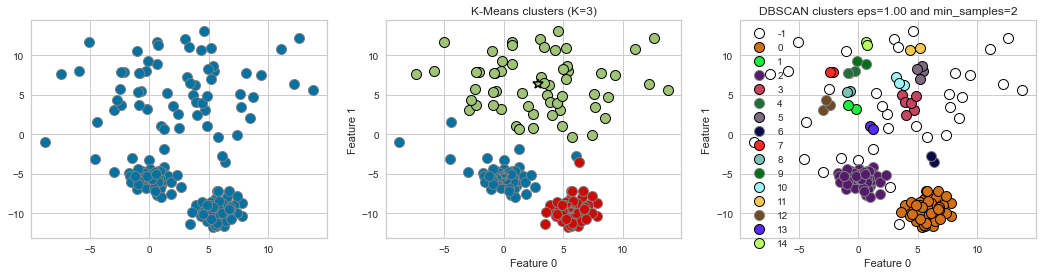

In [17]:
X_varied, y_varied = make_blobs(
    n_samples=200, cluster_std=[1.0, 5.0, 1.0], random_state=10
)
plot_k_means_dbscan_comparison(X_varied)

<br><br><br><br>

## Video 3: Hierarchical clustering  <a name="2"></a>

### Motivation

- Deciding how many clusters we want is a hard problem. 
- Often, it's useful to get a complete picture of similarity between points in our data before picking the number of clusters.  
- Hierarchical clustering is helpful in these scenarios.  

### Main idea

1. Start with each point in its own cluster. 
2. Greedily merge most similar *clusters*. 
3. Repeat Step 2 until you obtain only one cluster ($n-1$ times).

### Visualizing hierarchical clustering

- Hierarchical clustering can be visualized using a tool called **a dendrogram**. 
- Unfortunately, `sklearn` cannot do it so we will use the package `scipy.cluster.hierarchy` for hierarchical clustering.

### Hierarchical clustering input and output

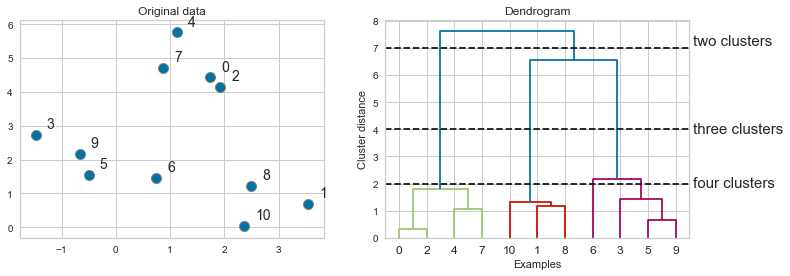

In [18]:
X, y = make_blobs(random_state=0, n_samples=11)
linkage_array = ward(X)
plot_X_dendrogram(X, linkage_array, label_n_clusters=True)

- Every point goes through the journey of being on its own (its own cluster) and getting merged with some other bigger clusters. 
- The intermediate steps in the process provide us clustering with different number of clusters. 

### Dendrogram

- Dendrogram is a tree-like plot. 
- On the x-axis we have data points. 
- On the y-axis we have distances between clusters. 
- We start with data points as leaves of the tree.  
- New parent node is created for every two clusters that are joined. 
- The length of each branch shown how far the merged clusters go. 
    - In the dendrogram above going from three clusters to two clusters means merging far apart points because the branches between three cluster to two clusters are long. 

### What do we mean by distance between clusters?

- We know how to measure distance between points (e.g., using Euclidean distance). 
- How do we measure distances between clusters? 
- The **linkage criteria** determines how to find similarity between clusters:
- Some example linkage criteria are: 
    - single linkage (minimum distance)
    - average linkage (average distance)
    - complete (or maximum) linkage (maximum distance)
    - ward linkage    

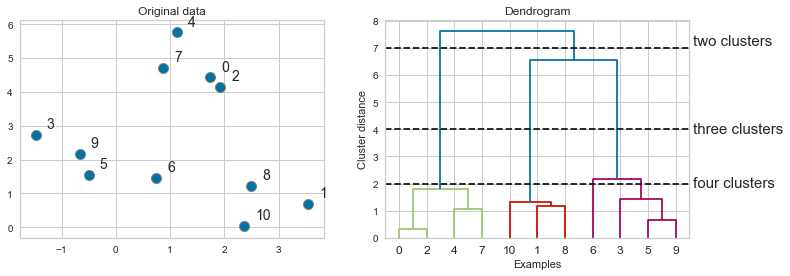

In [19]:
plot_X_dendrogram(X, linkage_array, label_n_clusters=True)

### `single` linkage 

- Merges two clusters that have the smallest minimum distance between all their points. 
- Let's use `scipy.cluster.hierarchy`'s `single` to get linkage information. 
- This method gives us matrix `Z` with the merging information. 

In [20]:
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)

Z = single(X)
columns = ["c1", "c2", "distance(c1, c2)", "# observations"]

In [21]:
pd.DataFrame(Z, columns=columns).head()

,c1,c2,"distance(c1, c2)",# observations
0,0.0,2.0,0.332095,2.0
1,5.0,9.0,0.645802,2.0
2,7.0,11.0,0.911272,3.0
3,3.0,12.0,0.989059,3.0
4,4.0,13.0,1.072565,4.0


- The linkage returns a matrix `Z` of shape n-1 by 4:
- The rows represent iterations. 
- First and second columns (c1 and c2 above): indexes of the clusters being merged.
- Third column (distance(c1, c2)): the distance between the clusters being merged.
- Fourth column (# observations): the number of examples in the newly formed cluster.

### Creating dendrogram with `single` linkage

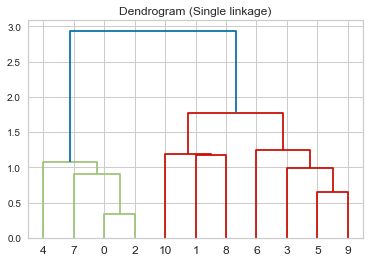

In [22]:
dendrogram(Z)
# Z is our single linkage matrix
plt.title("Dendrogram (Single linkage)");

### `average` linkage 

- Merges two clusters that have the smallest average distance between all their points. 
- `scipy.cluster.hierarchy`'s `average` method gives us matrix `Z` with the merging information using average linkage.   

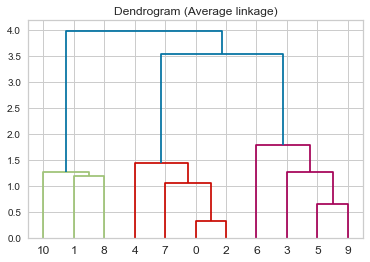

In [23]:
Z = average(X)
dendrogram(Z)
# Dendrogram with average linkage
plt.title("Dendrogram (Average linkage)");

### `complete` linkage

- Merges two clusters that have the smallest maximum distance between their points. 

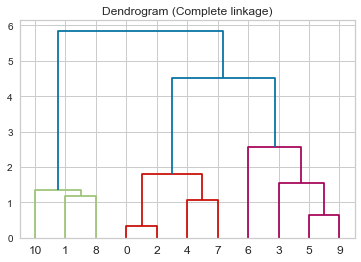

In [24]:
Z = complete(X)
dendrogram(Z)
# Dendrogram with complete linkage
plt.title("Dendrogram (Complete linkage)");

### `ward` linkage

- Picks two clusters to merge such that the variance within all clusters increases the least. 
- Often leads to equally sized clusters. 

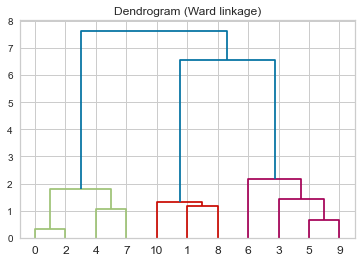

In [25]:
Z = ward(X)
dendrogram(Z)
# Dendrogram with ward linkage
plt.title("Dendrogram (Ward linkage)");

<br><br>

### Hierarchical clustering on UN Subvotes dataset

- Let's use a dataset of votes on UN resolutions:

In [26]:
votes_df = pd.read_csv("data/subvotes.csv")
votes = votes_df.pivot(index="country", columns="rcid")
votes = votes[np.sum(np.isnan(votes), axis=1) < 1]
print(votes.shape)
votes.head()

(17, 368)


vote                                               ...            \
rcid      2491 2492 2497 2504 2510 2526 2563 2610 2641 2645  ... 5321 5333   
country                                                      ...             
Australia  1.0  2.0  1.0  3.0  3.0  3.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
Austria    1.0  1.0  1.0  2.0  2.0  2.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   
Brazil     1.0  1.0  1.0  1.0  1.0  2.0  2.0  3.0  1.0  1.0  ...  1.0  1.0   
Colombia   1.0  1.0  1.0  1.0  1.0  2.0  1.0  2.0  1.0  1.0  ...  1.0  1.0   
Denmark    1.0  1.0  1.0  2.0  2.0  3.0  1.0  1.0  1.0  1.0  ...  1.0  1.0   

                                                   
rcid      5337 5358 5363 5364 5365 5367 5383 5385  
country                                            
Australia  1.0  1.0  2.0  1.0  3.0  1.0  3.0  3.0  
Austria    1.0  1.0  2.0  2.0  2.0  1.0  3.0  3.0  
Brazil     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Colombia   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
Denmark    1.0  1.0  2.0  2.0  2.0  1.0  3.0  3.0  

[5 rows x 368 columns]

- We have 17 countries and 368 votes. 
- Let's cluster countries based on how they vote. 

- We'll use [hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) here because we are interested in knowing whether the countries agreed or disagreed on resolutions. 

In [27]:
def plot_dendrogram(method="average", metric="hamming", w=22, h=12):
    Z = linkage(votes, method=method, metric=metric)
    fig, ax = plt.subplots(figsize=(w, h))
    dendrogram(Z, labels=votes.index, ax=ax)
    ax = plt.gca()
    ax.set_ylabel("Distance", fontsize=w)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80, fontsize=w)

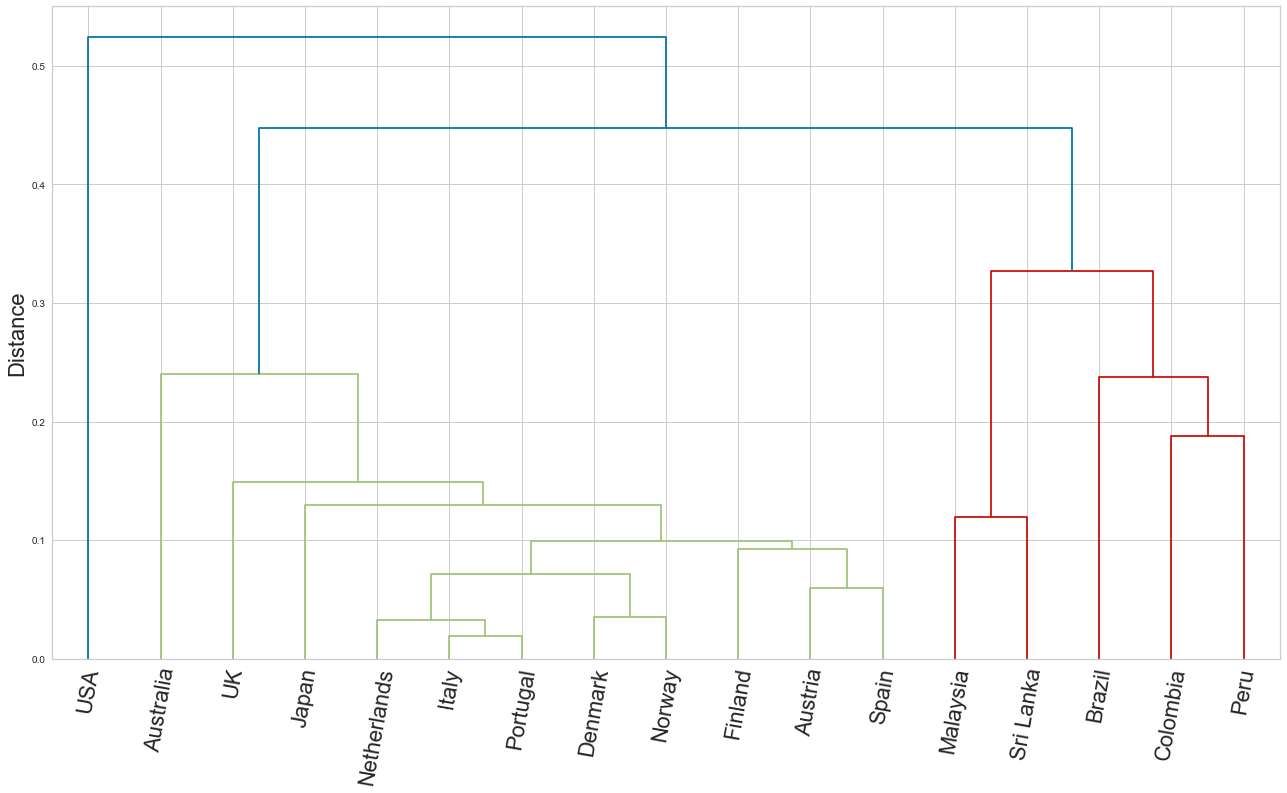

In [28]:
plot_dendrogram()

### Truncation
- If you want to truncate the tree in the dendrogram (specially when you have a big $n$) you can use the `truncate_mode`. 

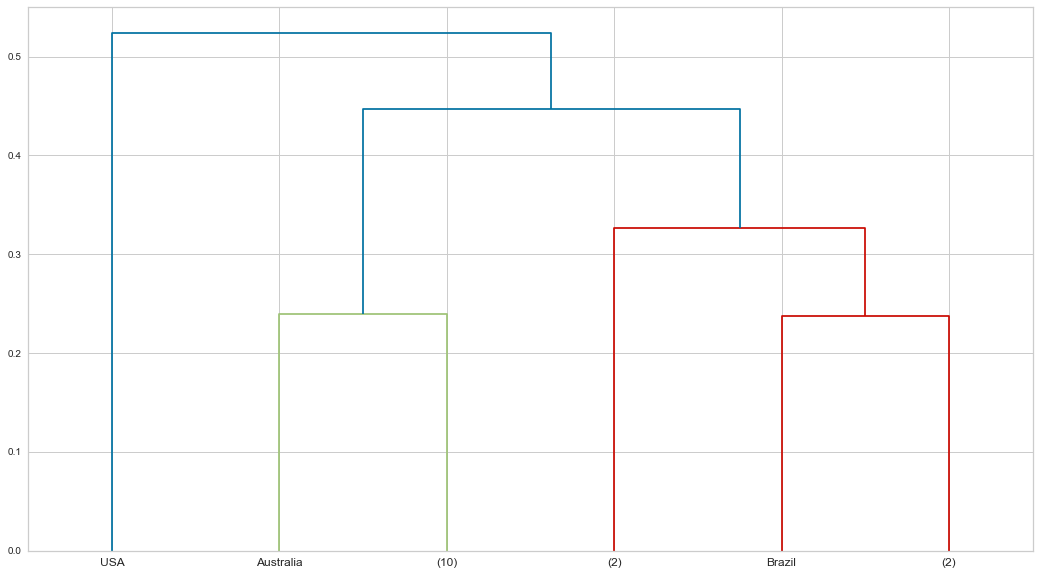

In [29]:
Z = linkage(votes, method="average", metric="hamming")
fig, ax = plt.subplots(figsize=(18, 10))
dendrogram(Z, p=6, truncate_mode="lastp", ax=ax, labels=votes.index);

### Truncation 

- Alternatively, you can truncate the tree down to $x$ levels from the single cluster:

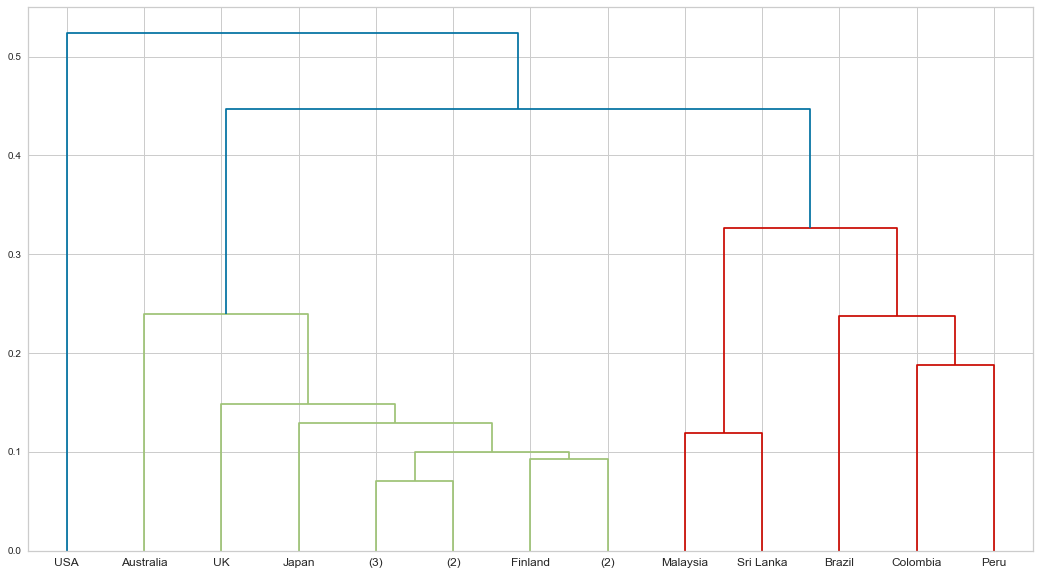

In [30]:
fig, ax = plt.subplots(figsize=(18, 10))
dendrogram(Z, 6, truncate_mode="level", ax=ax, labels=votes.index);

### Flat cluster 

- To bring the clustering to a "flat" format, we can use `fcluster`

In [31]:
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(Z, 6, criterion="maxclust")

In [32]:
pd.DataFrame(cluster_labels, votes.index)

,0
country,
Australia,2
Austria,1
Brazil,5
Colombia,4
Denmark,1
Finland,1
Italy,1
Japan,1
Malaysia,3


<br><br><br><br>

## Video 4: Applying clustering on face images <a name="1"></a>

- We'll be working with `sklearn`'s [Labeled Faces in the Wild dataset](https://scikit-learn.org/0.16/datasets/labeled_faces.html). 
- The dataset has images of celebrities from the early 2000s downloaded from the internet. 

> Credit: This example is based on the example from [here](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch03.html).

In [33]:
import matplotlib as mpl
from sklearn.datasets import fetch_lfw_people

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["image.cmap"] = "gray"

### Example images from the dataset

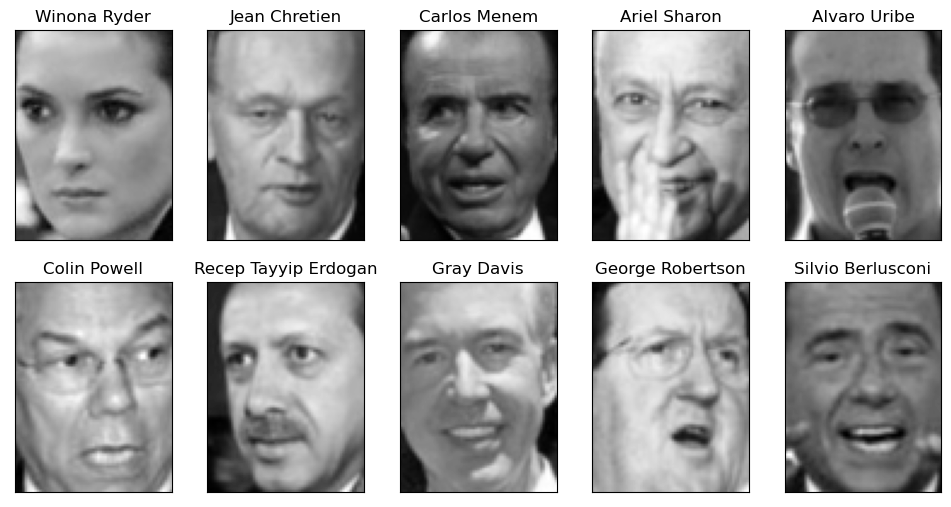

In [34]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

fig, axes = plt.subplots(2, 5, figsize=(12, 6), subplot_kw={"xticks": (), "yticks": ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [35]:
image_shape = people.images[0].shape
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


There are 3,023 images stored as arrays of 5655 pixels (87 by 65), of 62 different people:

In [36]:
# count how often each target appears
counts = np.bincount(people.target)
df = pd.DataFrame(counts, columns=["count"], index=people.target_names)
df.sort_values("count", ascending=False)

,count
George W Bush,530
Colin Powell,236
Tony Blair,144
Donald Rumsfeld,121
Gerhard Schroeder,109
...,...
Angelina Jolie,20
Jiang Zemin,20
Paul Bremer,20
Igor Ivanov,20


Let's make the data less skewed by taking only 20 images of the each person. 

In [37]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:20]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

In [38]:
X_people.shape

(1240, 5655)

In [39]:
# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.0

### Representation of images

- Representation of input is very important when you cluster examples. 
- In this example, we'll use PCA representation. (We'll learn about PCA next week.)

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0)
X_pca = pca.fit_transform(X_people)

### Clustering faces with K-Means

In [41]:
km = KMeans(n_clusters=10, random_state=10)
km.fit(X_pca)

KMeans(n_clusters=10, random_state=10)

What are the sizes of the clusters? 

In [42]:
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [ 36 309  65 108  89  39  98 210 168 118]


### Let's examine cluster centers

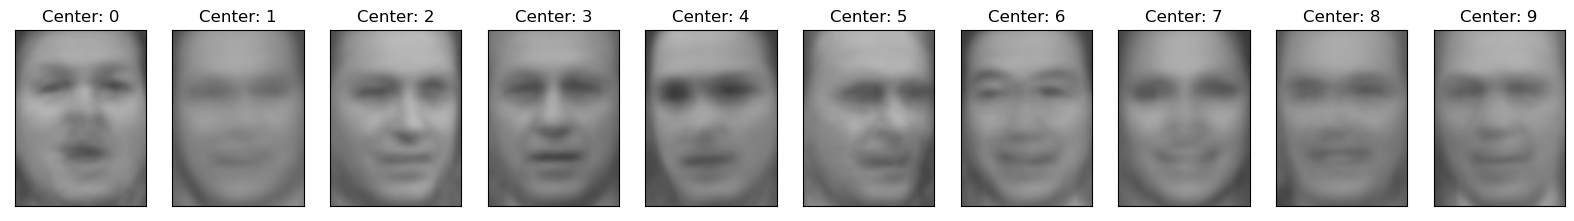

In [43]:
plot_faces_cluster_centers(km, pca)

- The centers found by K-Means are smooth versions of faces which makes sense. 
- Intuitively, they seem to capture some interesting characteristics of faces:
    - grumpy faces
    - faces somewhat rotated to the left/right
    - Smiley faces


### Examining images for different centers

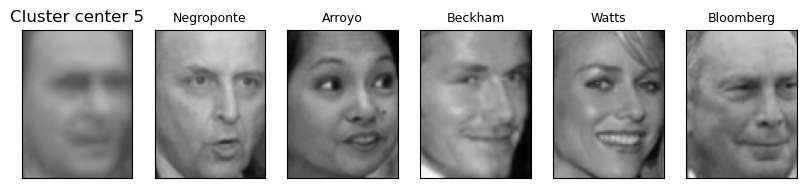

In [44]:
get_cluster_images(km, X_people, y_people, people.target_names, pca = pca, X_pca=X_pca, cluster=5)

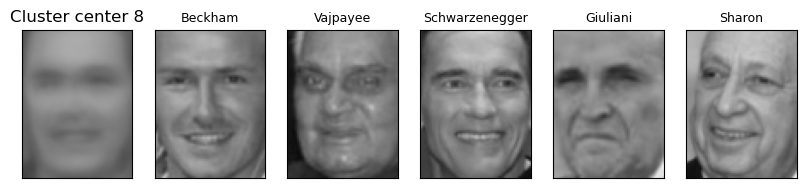

In [45]:
get_cluster_images(km, X_people, y_people, people.target_names, pca = pca, X_pca=X_pca, cluster=8)

### Let's try DBSCAN to cluster faces

In [46]:
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


With default hyperparameters, we get all points as noise points. 

### Tuning `eps`

In [47]:
for eps in [6, 8, 9, 10, 11, 12, 14]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=6
Number of clusters: 1
Cluster sizes: [1240]

eps=8
Number of clusters: 5
Cluster sizes: [1100  130    3    4    3]

eps=9
Number of clusters: 4
Cluster sizes: [841 393   3   3]

eps=10
Number of clusters: 2
Cluster sizes: [521 719]

eps=11
Number of clusters: 2
Cluster sizes: [282 958]

eps=12
Number of clusters: 2
Cluster sizes: [ 150 1090]

eps=14
Number of clusters: 2
Cluster sizes: [  45 1195]


### What are noise images? 

In [48]:
dbscan = DBSCAN(eps=14)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1  0]


In [49]:
def print_dbscan_noise_images(dbscan, labels, image_shape=(87, 65)):
    noise = X_people[labels == -1]

    fig, axes = plt.subplots(
        2, 9, subplot_kw={"xticks": (), "yticks": ()}, figsize=(12, 4)
    )
    for image, ax in zip(noise, axes.ravel()):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

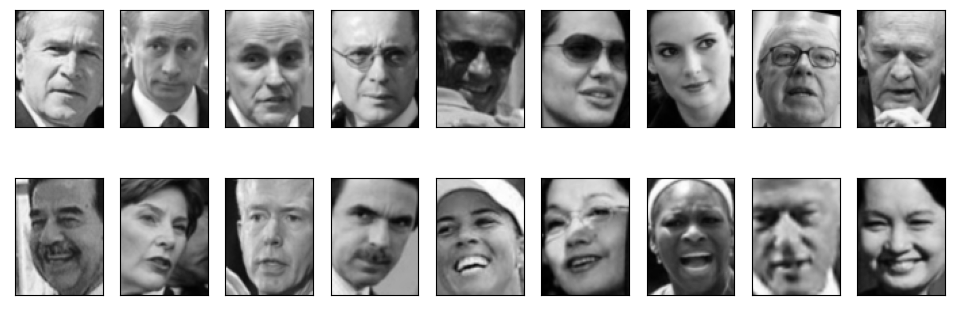

In [50]:
print_dbscan_noise_images(dbscan, labels)

- We can guess why these images are noise images. There are odd angles, cropping, sun glasses, hands near faces etc. 

### Examining DBSCAN clusters

In [51]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)
print("Number of clusters: {}".format(len(np.unique(labels))))
print("Cluster sizes: {}".format(np.bincount(labels + 1)))

Number of clusters: 5
Cluster sizes: [1227    4    3    3    3]


In [52]:
def print_dbscan_clusters(labels, image_shape=(87, 65)):
    i = 0
    for cluster in range(max(labels) + 1):
        mask = labels == cluster
        n_images = np.sum(mask)
        fig, axes = plt.subplots(
            1,
            n_images,
            figsize=(n_images * 1.5, 4),
            subplot_kw={"xticks": (), "yticks": ()},
        )
        for image, label, ax in zip(X_people[mask], y_people[mask], axes):
            ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
            ax.set_title("cluster %d" % (i))
        i += 1

- Some clusters correspond to people with distinct faces and facial expressions. 
- It's also capturing orientation of the face.  

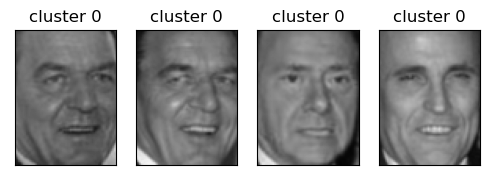

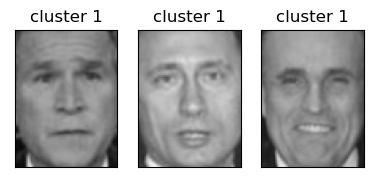

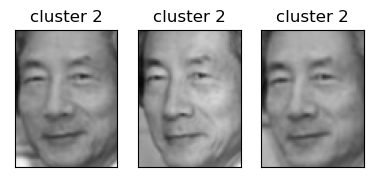

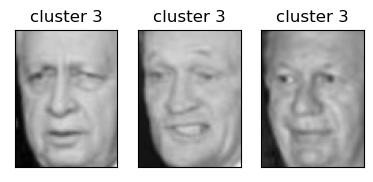

In [53]:
print_dbscan_clusters(labels)

<br><br><br><br>

## Video 5: Final comments and summary <a name="1"></a>

### Take-home message

- We saw three methods for clustering: K-Means, DBSCAN, and hierarchical clustering. 
- There are many more clustering algorithms out there which we didn't talk about. For example see [this overview of clustering methods](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods). 
- Two important aspects of clustering
    - Choice of distance metric
    - Data representation
- Choosing the appropriate number of clusters for a given problem is quite hard. 
- A lot of manual interpretation is involved in clustering. 

### A few comments on clustering evaluation

- If you know the ground truth, you can use metrics such as [adjusted random score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) or [normalized mutual information score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html). 
- We can't we use accuracy scores. 
    - Because the labels themselves are meaningless in clustering.  

### A few comments on clustering evaluation

- Usually ground truth is not available, and if it is available we would probably go with supervised models. 
- The silhouette score works for different clustering methods and it can give us some intuition about the quality of clusters. But it's not very interpretable on real-world datasets.

### A few comments on clustering evaluation
- One way to evaluate clustering is trying a number of clustering models and checking whether they give us similar clusters. 
- That said, even though all clustering models give similar results, the clusters might not capture the aspect you are interested in. 
- So you cannot really avoid manual analysis!! 

## Resources 

- Check out this nice comparison of [sklearn clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods).
- [DBSCAN Visualization](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)
- [Clustering with Scikit with GIFs](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)

<br><br><br><br>

## Questions for class discussion <a name="questions"></a>

### DBSCAN: True/False questions

1. With tiny epsilon (`eps` in `sklearn`) and min samples=1 (`min_samples=1` in `sklearn`) we can end up with each point in its own cluster. 
> V's answer: True.  

2. With a smaller value of `eps` and larger number for `min_samples` we would end up with a one big cluster. 
> V's answer: False. In this case, we would end up with many noise points. 

3. K-Means is more susceptible to outliers compared to DBSCAN.  
> V's answer: True. DBSCAN is robust to outliers. It just doesn't assign them to a cluster. In case of K-Means, on the other hand rather, outliers "pull" a cluster mean.  

4. In DBSCAN to be part of a cluster, each point must have at least `min_samples` neighbours in a given radius (including itself). 
> V's answer: False. This is not the case with border points. 

<br><br><br><br>

`n`

### True/False questions

1. Hierarchical clustering can only be applied to smaller datasets because dendrograms are hard to visualize for large datasets.
> V's answer: False. You can apply it on larger datasets and then visualize truncated dendrograms. 

2. In all the three clustering methods we saw (K-Means, DBSCAN, hierarchical clustering), there is a way to decide the granularity of clustering (i.e., how many clusters to pick). 
> V's answer: True. In K-Means we get to decide K, in DBSCAN 
In hierarchical clustering we get to decide where to cut the tree. 

3. To get robust clustering we can naively ensemble cluster labels (e.g., pick the most popular label) produced by different clustering methods. 
> V's answer: False. This is the label switching issue: the different clusterings might use different labels, so averaging directly would not make sense.

4. If you have a high silhouette score and very robust clustering, it means that it has captured the semantic meaning in the data of our interest.   
> V's answer: False. We might not get what we're interested in. For example, suppose we are interested in clustering old people vs young people, or people with beards and without beards, we might now be able to do that. 

<br><br><br><br>

### Time permitting 

- Discuss advantages and disadvantages of different clustering methods. 
- What are the parameters and hyperparameters of K-Means and DBSCAN? 
<br><br><br><br>